In [2]:
%matplotlib inline

!pip install pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

import pydotplus
from sklearn import tree
from IPython.display import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [4]:
from google.colab import drive
drive.mount('/content/drive')

class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/rusDfTS.csv"
df = pd.read_csv(dataset_path)

del df['Date']
del df['Hour']
#del df['Day']
#del df['TimeSlot']
#del df['Weekend']
#del df['WorkingHour']

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,16.081972,8.690398,7.360829,5.627949,10.859625,1
2,2,2,0,1,16.064222,8.711492,6.798350,5.695267,10.875454,1
3,2,2,0,1,15.726965,9.281037,6.458978,6.770428,11.357474,1
4,2,2,0,1,15.608629,9.414634,6.998203,6.968535,11.452773,1


In [0]:
import sys
sys.path.append('./')

In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [7]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2,2,0,1,16.081972,8.690398,7.360829,5.627949,10.859625,1
2,2,2,0,1,16.064222,8.711492,6.798350,5.695267,10.875454,1
3,2,2,0,1,15.726965,9.281037,6.458978,6.770428,11.357474,1
4,2,2,0,1,15.608629,9.414634,6.998203,6.968535,11.452773,1


# Data Partitioning

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# PCA

In [0]:
from sklearn.decomposition import PCA

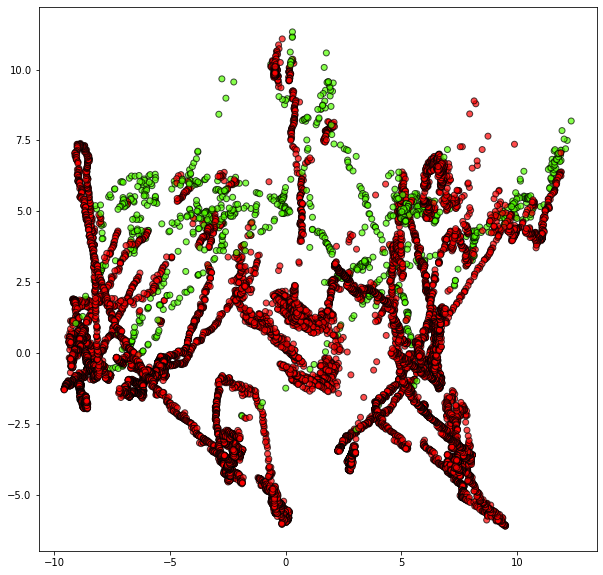

In [11]:
pca = PCA(n_components=2)

pca.fit(X)
X_pca = pca.transform(X)
plt.figure(figsize=(10,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [0]:
df['comp1'] = X_pca[:,0]
df['comp2'] = X_pca[:,1]
#df['comp3'] = X_pca[:,2]
#df['comp4'] = X_pca[:,3]
 
df.loc[df["Occupancy"] == 1, "Occupancy"] = 'Yes'
df.loc[df["Occupancy"] == 0, "Occupancy"] = 'No'

df.head()

,Day,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,comp1,comp2
0,2,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,Yes,-4.599620,10.770743
1,2,2,0,1,15.957720,8.711492,7.452585,5.343291,10.831549,Yes,-4.550521,10.840133
2,2,2,0,1,15.993220,8.669303,7.398537,5.432407,10.799950,Yes,-4.565146,10.879799
3,2,2,0,1,15.971032,8.595474,6.654588,5.481292,10.709977,Yes,-4.649525,10.585328
4,2,2,0,1,16.064222,8.648209,6.606039,5.522164,10.806016,Yes,-4.568006,10.668541


In [0]:
attributes = [col for col in df.columns if col != 'Occupancy']
X = df[attributes].values
y = df['Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=100, 
                                                    stratify=y)

X_train.shape, X_test.shape

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, 
                             min_samples_split=30, min_samples_leaf=10)
clf.fit(X_train, y_train)

for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Day 0.0
TimeSlot 0.0
Weekend 0.0
WorkingHour 0.0
Temperature 0.0
Humidity 0.0
Light 0.9977080356722537
CO2 0.002291964327746159
HumidityRatio 0.0
comp1 0.0
comp2 0.0


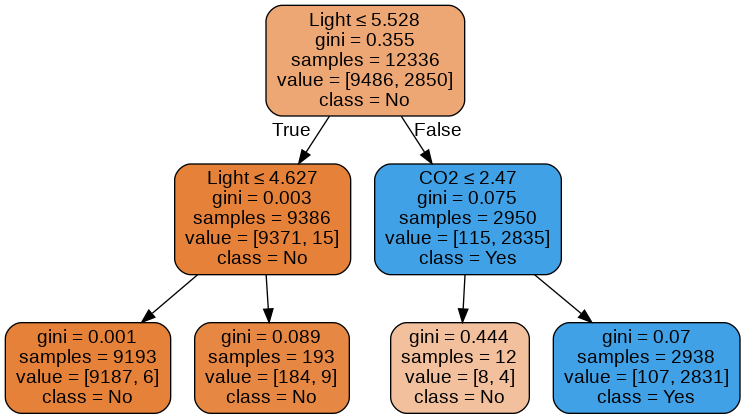

In [0]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=clf.classes_,  
                                filled=True, rounded=True,  
                                special_characters=True
                                )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [0]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred))

Accuracy 0.9891780155642024
F1-score [0.99292921 0.97694898]
              precision    recall  f1-score   support

          No       1.00      0.99      0.99      6324
         Yes       0.96      0.99      0.98      1900

    accuracy                           0.99      8224
   macro avg       0.98      0.99      0.98      8224
weighted avg       0.99      0.99      0.99      8224



In [0]:
del df['Day']
del df['TimeSlot']
del df['Weekend']
del df['WorkingHour']
del df['Temperature']
del df['Humidity']
del df['Light']
del df['CO2']
del df['HumidityRatio']

df.head()

,Occupancy,comp1,comp2
0,Yes,-4.599620,10.770743
1,Yes,-4.550521,10.840133
2,Yes,-4.565146,10.879799
3,Yes,-4.649525,10.585328
4,Yes,-4.568006,10.668541


In [0]:
attributes = [col for col in df.columns if col != 'Occupancy']
X = df[attributes].values
y = df['Occupancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, 
                                                    random_state=100, 
                                                    stratify=y)

X_train.shape, X_test.shape

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, 
                             min_samples_split=30, min_samples_leaf=10)
clf.fit(X_train, y_train)

for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

comp1 0.0639208032466393
comp2 0.9360791967533607


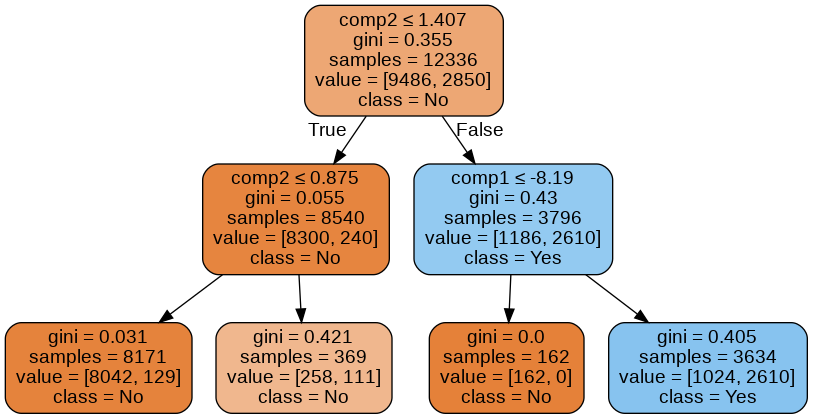

In [0]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=clf.classes_,  
                                filled=True, rounded=True,  
                                special_characters=True
                                )  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [0]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))

Accuracy 0.8999270428015564
F1-score [0.93209011 0.80988681]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.97      0.89      0.93      6324
         Yes       0.72      0.92      0.81      1900

    accuracy                           0.90      8224
   macro avg       0.85      0.91      0.87      8224
weighted avg       0.92      0.90      0.90      8224



#DECISION BOUNDARY

In [0]:
df.loc[df["Occupancy"] == 'Yes', "Occupancy"] = 1
df.loc[df["Occupancy"] == 'No', "Occupancy"] = 0


df['Occupancy2'] = df['Occupancy']
del df['Occupancy']
print (df)

          comp1      comp2 Occupancy2
0     -4.599620  10.770743          1
1     -4.550521  10.840133          1
2     -4.565146  10.879799          1
3     -4.649525  10.585328          1
4     -4.568006  10.668541          1
...         ...        ...        ...
20555  7.435477   2.213252          1
20556  7.501652   2.348326          1
20557  7.532142   2.436229          1
20558  7.979171   2.946772          1
20559  8.646965   4.210012          1

[20560 rows x 3 columns]


[0 0 0 ... 1 1 1]


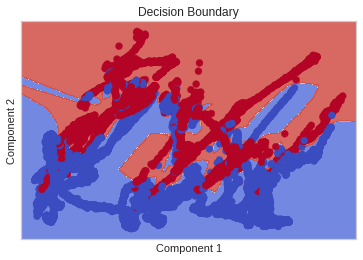

In [0]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.svm import LinearSVC

class_name = 'Occupancy2'

attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
y=y.astype('int')

X.shape[1]
y=y.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.subplot(1, 1, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')

clf.fit(X_train,y_train)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

print (Z)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Decision Boundary')

plt.show()

linear svm fa cagare per creare il decision boundary
non-linear svm è molto molto meglio
